In [1]:
# optional but useful for debugging - reimports modules after editing and saving .py files
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import astropy
from astropy import units as u
import astromet
import matplotlib.pyplot as plt
import matplotlib as mpl

In [3]:
print(dir(astromet))

['AU', 'AU_c', 'Delta', 'G', 'Galt', 'Gyr', 'T', 'Time', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'agis', 'agis_2d_prior', 'astromet', 'astropy', 'barycentricPosition', 'binaryMotion', 'bjd_to_bjyr', 'bjyr_to_bjd', 'bodyPos', 'c', 'dThetaEstimate', 'day', 'design_matrix', 'downweight', 'e', 'en_fit', 'findEtas', 'fit', 'fit_model', 'gaia_fit', 'get_gaiat', 'get_obmt', 'kpc', 'lSun', 'mSun', 'mas', 'mas2rad', 'mock_obs', 'name', 'np', 'params', 'period', 'sigString', 'sigmagamma', 'splitFit', 'splitInverse', 'splitNormal', 'track', 'u', 'year']


In [4]:
dr2period=22/12 # in years
edr3Period=34/12 # in years
mas=astromet.mas # conversion from degrees to milli-arcseconds

In [135]:
# an object wich holds all the necessary parameters to find the astrometric path
params=astromet.params()

# For this example we'll generate a random binary system

# center of mass parameters
params.RA=360*np.random.rand()
params.Dec=90*(-1+2*np.random.rand())
print('RA and Dec [degrees]: \n',params.RA,params.Dec)
params.pmRAc=10*np.random.randn()
params.pmDec=10*np.random.randn()
print('Proper motion in RA and Dec [mas/yr]: \n',params.pmRAc,params.pmDec)
params.pllx=1+9*np.random.rand()
print('Parallax [mas]: \n',params.pllx)

# binary parameters
params.M=1000*np.random.rand()**2
print('Mass of brightest source [mSun]: \n',params.M)
params.a=100*np.random.rand()
print('Semi-major axis [AU]: \n',params.a)
params.e=np.random.rand()
print('Eccentricity [dimensionless]: \n',params.e)
params.q=10*(np.random.rand()**4)
params.l=np.random.rand()
print('Light (l<1) and mass (q) ratios of binary [dimensionless]: \n',params.l,params.q)
params.vPhi=2*np.pi*np.random.rand()
params.vTheta=np.pi*np.random.rand()
print('On-sky projection angles (vPhi and vTheta) of binary [radians]: \n',params.vPhi,params.vTheta)
params.vOmega=2*np.pi*np.random.rand()
print('On-sky orientation angle of binary [radians]: \n',params.vOmega)
params.tPeri=2016+astromet.period(params)*np.random.rand()
print('Time of first binary periapse [years]: \n',params.tPeri)

print('\nPeriod [years]: \n',astromet.period(params))

RA and Dec [degrees]: 
 168.822791746732 -52.67101756954034
Proper motion in RA and Dec [mas/yr]: 
 7.475988873971572 -2.479795383222872
Parallax [mas]: 
 4.9486674220605735
Mass of brightest source [mSun]: 
 818.576627957461
Semi-major axis [AU]: 
 10.448273014646414
Eccentricity [dimensionless]: 
 0.8343208178025897
Light (l<1) and mass (q) ratios of binary [dimensionless]: 
 0.2468491575204601 2.0907266576304272e-05
On-sky projection angles (vPhi and vTheta) of binary [radians]: 
 4.51073351780632 1.551335064467769
On-sky orientation angle of binary [radians]: 
 5.608334008004396
Time of first binary periapse [years]: 
 2016.0984934731916

Period [years]: 
 1.1774357303751846


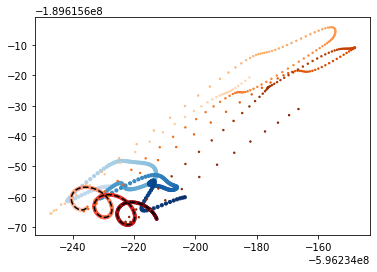

In [136]:
# calculating the on-sky path
plotts=np.linspace(2016-0.5*edr3Period,2016+0.5*edr3Period,256)

# first just the c.o.m. 
raccoms,deccoms=astromet.track(plotts,params,comOnly=True)
# then the positions of the centre of light, and both masses
raccols,deccols,rac1s,dec1s,rac2s,dec2s=astromet.track(plotts,params,allComponents=True)

# colouring by time (white to coloured)
ccols=mpl.cm.Blues(np.interp(plotts,[plotts[0],plotts[-1]],[0.2,1]))
c1s=mpl.cm.Reds(np.interp(plotts,[plotts[0],plotts[-1]],[0.2,1]))
c2s=mpl.cm.Oranges(np.interp(plotts,[plotts[0],plotts[-1]],[0.2,1]))

ss=np.ones_like(plotts)

# plotting
trackPlot=plt.gca()
trackPlot.plot(raccoms,deccoms,c='k',ls='--')
trackPlot.scatter(raccols,deccols,c=ccols,s=10)
trackPlot.scatter(rac1s,dec1s,c=c1s,s=10/(1+params.l))
trackPlot.scatter(rac2s,dec2s,c=c2s,s=10*params.l/(1+params.l))
plt.show()

0.3304034034155648
0.7835099431207907
1.8579948772411023
4.406000197143605
10.448273014646414
24.77675989650674
58.75495693006828
139.32995994124695
330.4034034155648


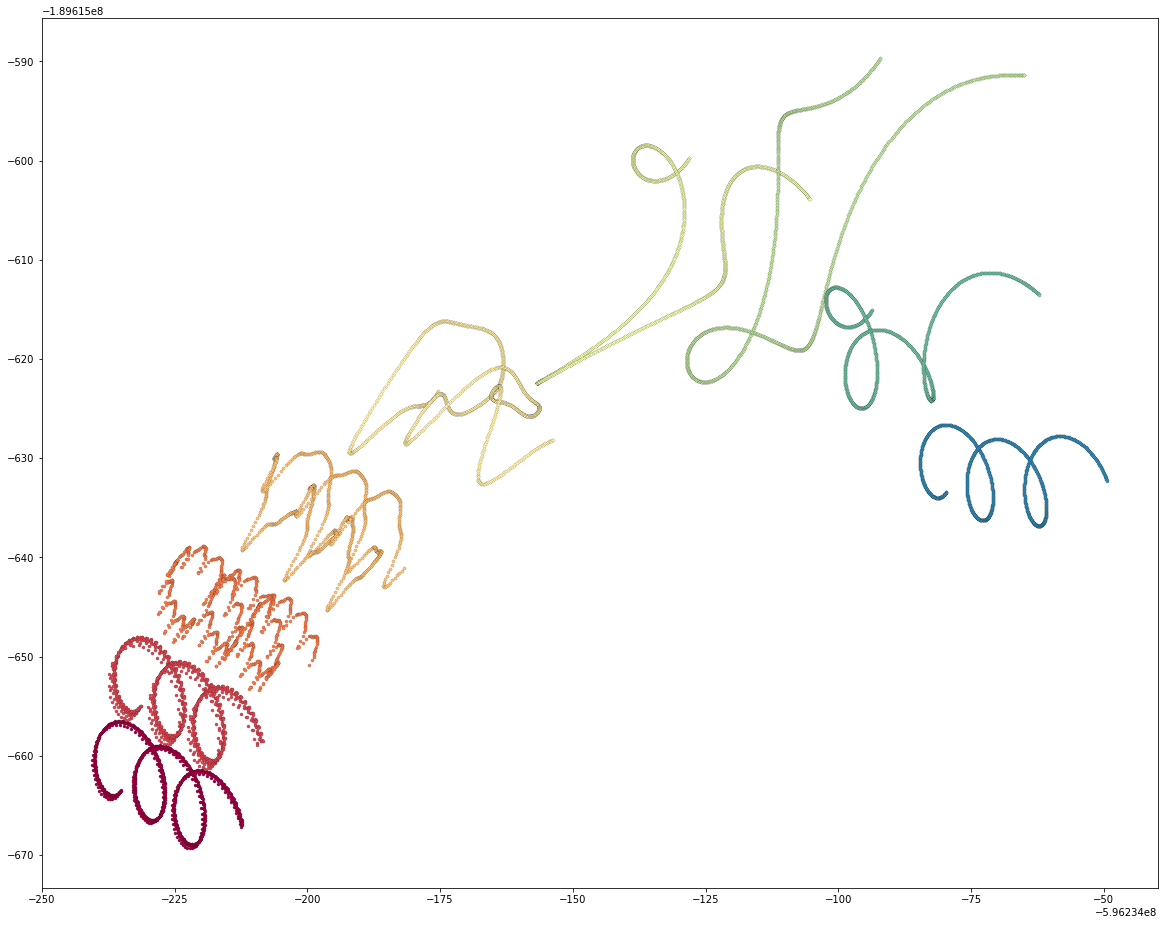

In [206]:
ra=168.822791746732
dec=-52.67101756954034

pmra=7.475988873971572
pmdec=-2.479795383222872
pllx=4.9486674220605735
M=818.576627957461
a=10.448273014646414
e=0.8343208178025897
l=0.2468491575204601
q=2.0907266576304272e-05
vPhi=4.51073351780632
vTheta=1.551335064467769
vOmega=5.608334008004396
t0=2016.0984934731916

ntrack=9
alist=a*10**np.linspace(-1.5,1.5,ntrack)

plotts=np.linspace(2016-0.5*edr3Period,2016+0.5*edr3Period,1000)
qFig=plt.figure(figsize=(20,16))
qPl=plt.gca()

for i in range(ntrack):
    params=astromet.params()

    params.RA=ra-2*(i**2)*astromet.mas
    params.Dec=dec+8*i*astromet.mas
    params.pmRAc=pmra
    params.pmDec=pmdec
    params.pllx=pllx
    params.M=M
    params.a=alist[i]
    print(params.a)
    params.e=e
    params.q=q
    params.l=l
    params.vPhi=vPhi
    params.vTheta=vTheta
    params.vOmega=vOmega
    params.tPeri=t0
    
    raccols,deccols=astromet.track(plotts,params)
    c=mpl.cm.Spectral(i/ntrack)
    qPl.scatter(raccols,deccols,color=c,s=10,zorder=2,edgecolor='k',lw=0.1)
    #qPl.scatter(raccols,deccols,color='k',s=16,zorder=1)
    
plt.savefig('astrometricTracksExample.pdf')
plt.show()

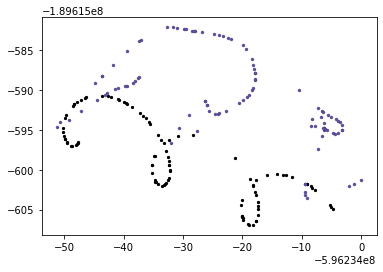

In [256]:
plotts=2016+edr3Period*(-0.5+np.random.rand(100))
qPl=plt.gca()
params.pmRAc=2*pmra
params.pmDec=2*pmdec
params.a=alist[4]
raccoms,deccoms=astromet.track(plotts,params,comOnly=True)
raccols,deccols=astromet.track(plotts,params)

phis=360*np.random.rand(plotts.size)

talls=np.hstack([plotts])
phialls=np.hstack([phis])
racalls=np.hstack([raccols])
decalls=np.hstack([deccols])
erralls=np.hstack([0.3*np.ones(plotts.size)])

xs=astromet.mock_obs(phialls,racalls,decalls,errs=erralls)

results=astromet.gaia_fit(talls,xs,phialls,erralls,params.RA,params.Dec)


c=mpl.cm.Spectral(i/ntrack)
qPl.scatter(raccoms,deccoms,color='k',s=5,zorder=2)
qPl.scatter(raccols,deccols,color=c,s=10,zorder=2,edgecolor='k',lw=0.1)
plt.show()

In [259]:
print(params.RA)
print(params.Dec)
print(params.pmRAc)
print(params.pmDec)
print(params.pllx)
print(results)

168.82275619117647
-52.67099979176256
14.951977747943143
-4.959590766445744
4.9486674220605735
{'astrometric_matched_transits': 100, 'visibility_periods_used': 76, 'astrometric_n_obs_al': 900, 'astrometric_params_solved': 31, 'ra': -273.12503796994673, 'ra_error': 0.09605754191048148, 'dec': -52.670997354592686, 'dec_error': 0.08270274725687933, 'ra_dec_corr': 0.052613815058903425, 'parallax': 4.938809335231781, 'parallax_error': 0.09059054038218395, 'ra_parallax_corr': -0.056950055277707835, 'dec_parallax_corr': 0.112838406445908, 'pmra': 14.785042226314545, 'pmra_error': 0.12313804566824318, 'ra_pmra_corr': 0.1390817809560443, 'dec_pmra_corr': 0.09412667598197501, 'parallax_pmra_corr': -0.05608509208321064, 'pmdec': -4.541873425245285, 'pmdec_error': 0.09790564427477708, 'ra_pmdec_corr': 0.07755997709767076, 'dec_pmdec_corr': 0.28887013880646106, 'parallax_pmdec_corr': -0.009218773431788615, 'pmra_pmdec_corr': 0.1892446270985694, 'astrometric_excess_noise': 2.9477433654141536, 'astro

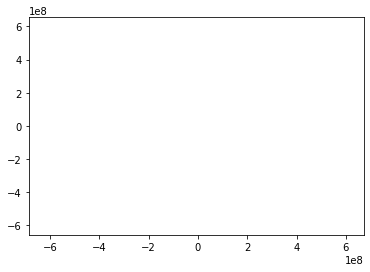

In [242]:
# simulating observables

# times when system is observed [years, CE]
ts=2016+np.sort(edr3Period*(-0.5+np.random.rand(50)))

racs,decs=astromet.track(ts,params)

phis=360*np.random.rand(ts.size)

talls=np.hstack([ts,ts])
phialls=np.hstack([phis,phis-90])
racalls=np.hstack([racs,racs])
decalls=np.hstack([decs,decs])
erralls=np.hstack([0.3*np.ones(ts.size),np.ones(ts.size)])

xs=astromet.mock_obs(phialls,racalls,decalls,errs=erralls)

results=astromet.gaia_fit(talls,xs,phialls,erralls,params.RA,params.Dec)

scanPlot=plt.gca()
for i in range(xs.size):
    xvals=[(xs[i]-erralls[i])*np.sin(phialls[i]),(xs[i]+erralls[i])*np.sin(phialls[i])]
    yvals=[(xs[i]-erralls[i])*np.cos(phialls[i]),(xs[i]+erralls[i])*np.cos(phialls[i])]
    scanPlot.plot(xvals,yvals)
plt.show()

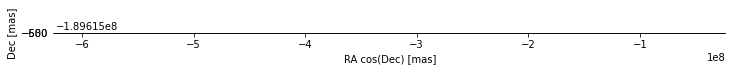

In [236]:
# plotting on sky motion
qFig=plt.figure(figsize=(12,8))
qPl=plt.gca() # defining matplotlib axis object on which to plot

cs=mpl.cm.twilight_shifted(np.interp(ts,[ts[0],ts[-1]],[0,1])) # optional, but I like to color by time
cs[:,3]=0.5

# plotting the datapoints (ideally as error ellipses -
# if that fails comment out the for loop and use the simpler scatter plot instead)
astError=0.3
for i in range(racs.size):
    ell = mpl.patches.Ellipse(xy=(racs[i]*np.cos(decs[i]*np.pi/180), decs[i]),
                  width=2*astError*mas, height=2*astError*mas,
                  angle=0)
    ell.set_facecolor(cs[i])
    ell.set_edgecolor('k')
    qPl.add_artist(ell)
#qPl.scatter(ras*np.cos(decs*np.pi/180),decs,s=50,c=cs,zorder=2,edgecolors='k',lw=1)

# uniformly sampled times for plotting true paths
tUniform=np.linspace(ts[0],ts[-1],1000)

# optional - adding the centre of mass motion (black) for reference
comRas,comDecs=astromet.track(tUniform,params,comOnly=True)
qPl.plot(comRas*np.cos(comDecs*np.pi/180),comDecs,lw=1,c='k',alpha=0.5,zorder=1)

# optional - adding the centre of mass motion (red) for reference
trueRas,trueDecs=astromet.track(tUniform,params)
qPl.plot(trueRas*np.cos(trueDecs*np.pi/180),trueDecs,lw=2,c='darkred',alpha=0.5,zorder=1,ls='--')

# optional - adding fitted motion (blue)
for i in range(32):
    randRa=results['ra']#+results['ra_error']*np.random.randn()
    randDec=results['dec']#+results['dec_error']*np.random.randn()
    randPmRa=results['pmra']+results['pmra_error']*np.random.randn()
    randPmDec=results['pmdec']+results['pmdec_error']*np.random.randn()
    randPllx=results['parallax']+results['parallax_error']*np.random.randn()
    
    fitPs=astromet.params()
    fitPs.RA=randRa
    fitPs.Dec=randDec
    fitPs.pmRA=randPmRa
    fitPs.pmDec=randPmDec
    fitPs.pllx=randPllx
    bestRas,bestDecs=astromet.track(tUniform,fitPs,comOnly=True)
    qPl.plot(bestRas*np.cos(bestDecs*np.pi/180),bestDecs,lw=1,c='darkblue',alpha=0.1,zorder=0)
fitPs=astromet.params()
fitPs.RA=results['ra']
fitPs.Dec=results['dec']
fitPs.pmRA=results['pmra']
fitPs.pmDec=results['pmdec']
fitPs.pllx=results['parallax']
bestRas,bestDecs=astromet.track(tUniform,fitPs,comOnly=True)
qPl.plot(bestRas*np.cos(bestDecs*np.pi/180),bestDecs,lw=2,c='darkblue',alpha=0.8,zorder=0,ls='--')

# adding initial position and proper motion as arrow
#qPl.arrow(np.median(ras*np.cos(decs*np.pi/180)),np.median(decs),mas*params.pmRA,mas*params.pmDec,color='k',alpha=0.5)

qPl.set_xlabel('RA cos(Dec) [mas]')
qPl.set_ylabel('Dec [mas]')
qPl.set_aspect('equal')

plt.show()

In [373]:
print('Period: ',astromet.period(params))
print('eccentricity: ',params.e)
uweobs=astromet.uwe(ts,ras,decs,fitParams,astError=1)
print('____________UWE obs: ',uweobs)
dthetapred=astromet.dThetaEstimate(params,ts[0],ts[-1])
print('____________UWE predicted: ',np.sqrt(1+(dthetapred)**2))
dthetasimp=astromet.dThetaEstimate(params,ts[0],ts[0]+params.P)
print('____________UWE simple: ',np.sqrt(1+(dthetasimp)**2))

Period:  3.1434281947297515
eccentricity:  0.8245063389081532
____________UWE obs:  1.0161110129695214
____________UWE predicted:  1.0
____________UWE simple:  1.0
